In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.linalg import toeplitz
import pandas as pd
from scipy import sparse

In [ ]:
case=0
SAMPLE_INDEX=0

# key_noise_train, key_noise_test =  random.split(random.PRNGKey(2))
key_noise_train = random.PRNGKey(case)
key_noise_test = random.PRNGKey(case)

Net_work_key = 100
# ## 1. Loading data by pandas
# Neural network models
num_train = 10000
num_test = 500


test_input_file_name =   'poisson_2D_state_obs_test_o10_d' + str(num_test)+ '_n15_AC_1_1_pt5'
test_output_file_name =  'poisson_2D_parameter_test_d' + str(num_test)+ '_n15_AC_1_1_pt5'


df_test_Observations = pd.read_csv('Heat_equation/data/' + test_input_file_name + '.csv') 
df_test_Parameters = pd.read_csv('Heat_equation/data/' + test_output_file_name + '.csv')


test_Observations_synthetic = np.reshape(df_test_Observations.to_numpy(), (num_test,-1))
test_Parameters = np.reshape(df_test_Parameters.to_numpy(), (num_test,-1))

# ### 1.1 Add noise
noise_level = 0.01
# train_Observations = train_Observations_synthetic + noise_level * (random.normal(key_noise_train, shape=train_Observations_synthetic.shape)) * jnp.reshape(jnp.max(train_Observations_synthetic, axis = 1), (num_train, 1))
test_Observations = test_Observations_synthetic + noise_level * (random.normal(key_noise_test, shape=test_Observations_synthetic.shape)) * jnp.reshape(jnp.max(test_Observations_synthetic, axis = 1), (num_test, 1))

# Extract single sample
single_test_observation = test_Observations[SAMPLE_INDEX, :]
single_test_parameter = test_Parameters[SAMPLE_INDEX, :] 


# ### 1.2 Load Eigenvalue, Eigenvectors, observed indices, prematrices

# Physical model information
n = 15
dimension_of_PoI = (n + 1)**2 # external force field
num_observation = 10 # number of observed points
num_truncated_series = 15

df_Eigen = pd.read_csv('Heat_equation/data/prior_mean_n15_AC_1_1_pt5' + '.csv') 
df_Sigma = pd.read_csv('Heat_equation/data/prior_covariance_n15_AC_1_1_pt5' + '.csv') 

Eigen = np.reshape(df_Eigen.to_numpy(), (dimension_of_PoI, num_truncated_series))
Sigma = np.reshape(df_Sigma.to_numpy(), (num_truncated_series, num_truncated_series))

df_obs = pd.read_csv('Heat_equation/data/poisson_2D_obs_indices_o10_n15' + '.csv')
obs_indices = np.reshape(df_obs.to_numpy(), (num_observation,-1))


boundary_matrix = sparse.load_npz('Heat_equation/data/boundary_matrix_n15' + '.npz')
pre_mat_stiff_sparse = sparse.load_npz('Heat_equation/data/prestiffness_n15' + '.npz')
load_vector_n15 = sparse.load_npz('Heat_equation/data/load_vector_n15' + '.npz')
load_vector = sparse.csr_matrix.todense(load_vector_n15).T


df_free_index = pd.read_csv('Heat_equation/data/prior_covariance_cholesky_n15_AC_1_1_pt5' + '.csv')
free_index = df_free_index.to_numpy()

i = 0
obs_transfered = []
for free_ind in free_index:
    if (free_ind in obs_indices):
        obs_transfered.append(i)
    i += 1

jjj = 0
obs_operator = np.zeros((num_observation, free_index.shape[0]))
for obs_index in obs_transfered:
    
    obs_operator[jjj, obs_index] = 1
    jjj+= 1
    
obs_operator = jax.numpy.asarray(obs_operator)  
Eigen = jax.numpy.asarray(Eigen)
Sigma = jax.numpy.asarray(Sigma)
pre_mat_stiff = jax.numpy.asarray(pre_mat_stiff_sparse.todense())

values = np.asarray([[pre_mat_stiff_sparse[i,j]] for i, j in zip(*pre_mat_stiff_sparse.nonzero())]).squeeze()
rows, cols = pre_mat_stiff_sparse.nonzero()

from functools import partial
partial(jax.jit, static_argnums=(4))
def sp_matmul(values, rows, cols, B, shape):
    """
    Arguments:
        A: (N, M) sparse matrix represented as a tuple (indexes, values)
        B: (M,K) dense matrix
        shape: value of N
    Returns:
        (N, K) dense matrix
    """
    
    # assert B.ndim == 2
    B = jnp.expand_dims(B, axis = 1)
    in_ = B.take(cols, axis=0)
    prod = in_*values[:, None]
    res = jax.ops.segment_sum(prod, rows, shape)
    
    return res

# Inverse-learned-network
def forward_op(x):
    
    parameter_of_interest = jnp.dot(x, jnp.transpose(jnp.dot(Eigen, Sigma)))
    stiff = sp_matmul(values, rows, cols, jnp.exp(parameter_of_interest), dimension_of_PoI**2)
    stiff = jnp.reshape(stiff, (dimension_of_PoI, dimension_of_PoI))
    
    A = jnp.squeeze(jnp.take(stiff,free_index, axis=1))

    B = jnp.squeeze(jnp.take(A,free_index, axis=0))
    
    state = jnp.linalg.solve(B, load_vector)
    
    out_pred = jnp.dot(obs_operator, state).squeeze()
    
    return out_pred

2025-08-03 23:19:39.694928: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.6 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
test_Observations_synthetic[0,]

array([0.27519805, 1.0305913 , 0.95798504, 1.45802541, 0.15510106,
       0.67373638, 1.62014449, 1.67299335, 2.30457391, 0.54690729])

In [3]:
forward_op(single_test_parameter)

Array([0.27519805, 1.0305913 , 0.95798504, 1.45802541, 0.15510106,
       0.67373638, 1.62014449, 1.67299335, 2.30457391, 0.54690729],      dtype=float64)

In [5]:
inverted_params = np.load('Heat_equation/Single_Sample_0_Best_Summary_case_0_Noise_01_inverse_solution.npy')


Text(0.5, 1.0, 'Inverted Parameters vs Ground Truth')

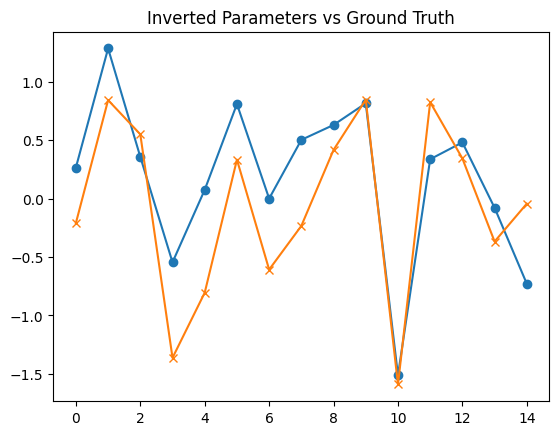

In [6]:
plt.plot(inverted_params, label='Inverted Parameters', marker='o')
plt.plot(single_test_parameter, label='Ground Truth', marker='x')
plt.title('Inverted Parameters vs Ground Truth')

# Bayesian framework

Single Sample Bayesian Inverse Problem with HMC
Alpha = 2e3 (Fixed)
Bayesian Analysis Setup:
  Sample index: 0
  Parameter dimension: 15
  Observation dimension: 10
  Regularization α: 6.74e-01
  Noise level: 1.0%
  Observation std: 0.027244

Running HMC sampling...
Starting warmup...
Warmup 200/500, accept_prob: 1.000, avg_accept: 0.997, epsilon: 0.0293
Warmup 400/500, accept_prob: 0.982, avg_accept: 0.989, epsilon: 0.0368
Adapted mass matrix from 249 warmup samples
Final warmup epsilon: 0.0368
Starting sampling...
Sample 100/5000, Accept rate: 1.000
Sample 200/5000, Accept rate: 0.995
Sample 300/5000, Accept rate: 0.997
Sample 400/5000, Accept rate: 0.993
Sample 500/5000, Accept rate: 0.994
Sample 600/5000, Accept rate: 0.992
Sample 700/5000, Accept rate: 0.990
Sample 800/5000, Accept rate: 0.988
Sample 900/5000, Accept rate: 0.988
Sample 1000/5000, Accept rate: 0.988
Sample 1100/5000, Accept rate: 0.986
Sample 1200/5000, Accept rate: 0.986
Sample 1300/5000, Accept rate: 0.985
Sample

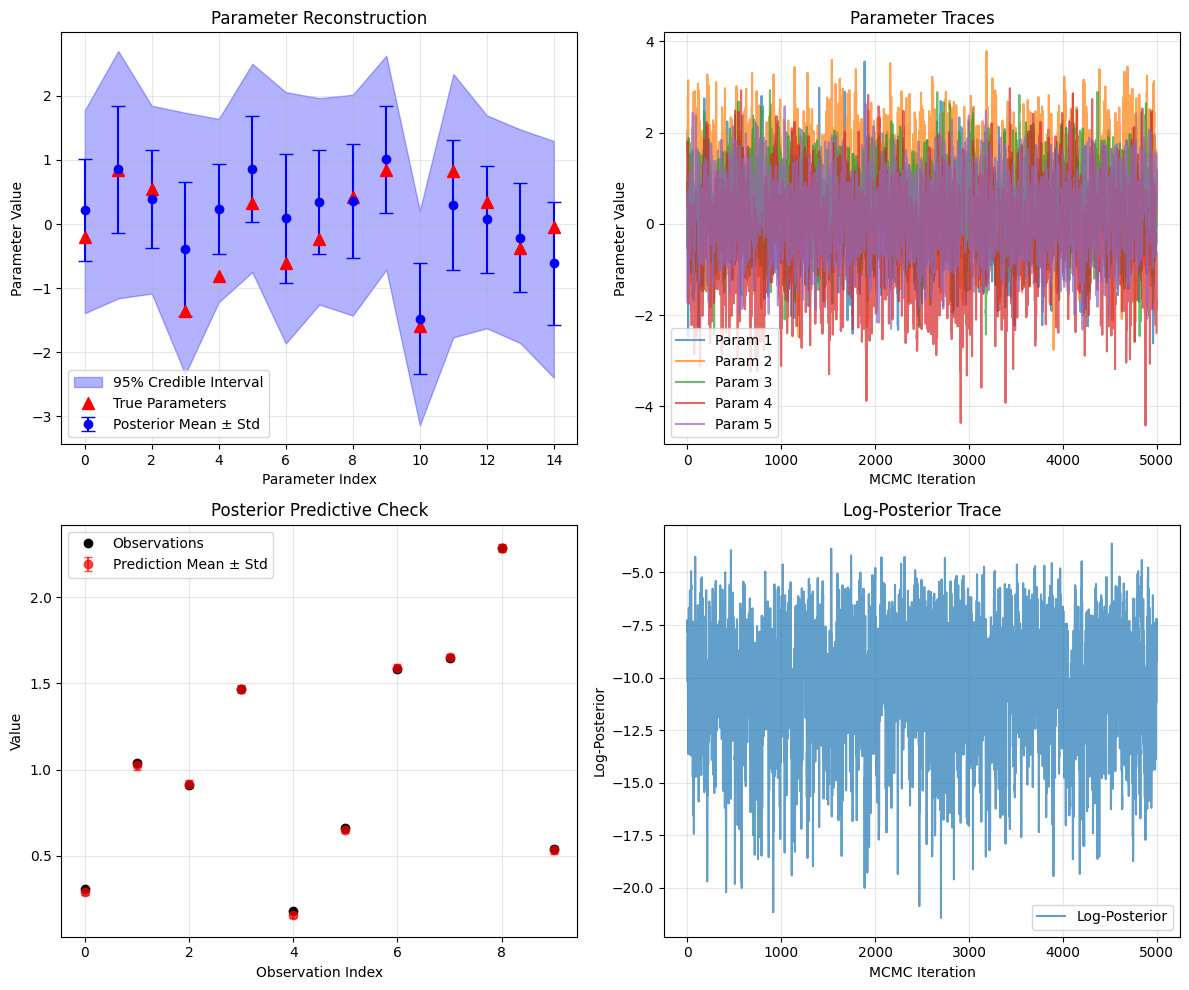


Results saved to: bayesian_single_sample_0_alpha_7e-01.npy

Analysis complete!


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
from scipy import sparse

# Set JAX to use double precision for better numerical accuracy
jax.config.update("jax_enable_x64", True)

class JAXHMCBayesianInverse:
    """
    HMC sampler for general Bayesian inverse problems using JAX
    Handles nonlinear forward operators without analytical solutions
    """
    
    def __init__(self, forward_operator, y_obs, sigma, prior_mean, prior_cov_inv, initial_x):
        """
        Parameters:
        -----------
        forward_operator : callable
            Nonlinear forward operator function: x -> G(x)
        y_obs : array
            Observed data
        sigma : float or array
            Observation noise standard deviation
        prior_mean : array
            Prior mean
        prior_cov_inv : array
            Prior precision matrix (inverse covariance)
        initial_x : array
            Initial parameter guess
        """
        # Convert to JAX arrays
        self.y_obs = jnp.array(y_obs)
        self.sigma = jnp.array(sigma) if np.isscalar(sigma) else jnp.array(sigma)
        self.prior_mean = jnp.array(prior_mean)
        self.prior_cov_inv = jnp.array(prior_cov_inv)
        self.x_init = jnp.array(initial_x)
        
        # Store forward operator
        self.forward_operator = jit(forward_operator)
        
        # HMC parameters
        self.epsilon = 0.01  # Step size
        self.n_leapfrog = 20  # Number of leapfrog steps
        self.mass_matrix = jnp.eye(len(initial_x))
        
        # Compile functions
        self._compile_functions()
    
    def _compile_functions(self):
        """Compile JAX functions for efficiency"""
        
        @jit
        def log_likelihood(x):
            """Compute log-likelihood for potentially nonlinear forward operator"""
            predictions = self.forward_operator(x)
            residual = predictions - self.y_obs
            
            # Handle both scalar and vector sigma
            if jnp.isscalar(self.sigma):
                return -0.5 * jnp.sum(residual**2) / self.sigma**2
            else:
                # Diagonal covariance case
                return -0.5 * jnp.sum((residual / self.sigma)**2)
        
        @jit
        def log_prior(x):
            """Compute log-prior using mean and precision matrix"""
            x_centered = x - self.prior_mean
            return -0.5 * jnp.dot(x_centered, self.prior_cov_inv @ x_centered)
        
        @jit
        def log_posterior(x):
            """Compute log-posterior"""
            return log_likelihood(x) + log_prior(x)
        
        # Store compiled functions
        self.log_posterior_fn = log_posterior
        self.log_likelihood_fn = log_likelihood
        self.log_prior_fn = log_prior
        self.grad_log_posterior_fn = jit(grad(log_posterior))
        
        # Combined function for efficiency
        @jit
        def log_posterior_and_grad(x):
            return log_posterior(x), grad(log_posterior)(x)
        
        self.log_posterior_and_grad_fn = log_posterior_and_grad
    
    @partial(jit, static_argnums=(0,))
    def leapfrog_step(self, x, momentum, epsilon):
        """Single leapfrog integration step"""
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        # Full step for position
        mass_inv = jnp.linalg.solve(self.mass_matrix, momentum)
        x = x + epsilon * mass_inv
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        return x, momentum
    
    @partial(jit, static_argnums=(0,))
    def compute_energy(self, x, momentum):
        """Compute Hamiltonian energy"""
        log_p = self.log_posterior_fn(x)
        kinetic = 0.5 * jnp.dot(momentum, jnp.linalg.solve(self.mass_matrix, momentum))
        return -log_p + kinetic
    
    def hmc_step(self, x_current, key):
        """Complete HMC step"""
        
        # Sample momentum
        key, subkey = random.split(key)
        momentum = random.normal(subkey, shape=x_current.shape)
        
        # Current energy
        energy_current = self.compute_energy(x_current, momentum)
        
        # Leapfrog trajectory
        x_prop = x_current
        momentum_prop = momentum
        
        for _ in range(self.n_leapfrog):
            x_prop, momentum_prop = self.leapfrog_step(
                x_prop, momentum_prop, self.epsilon
            )
        
        # Negate momentum for reversibility
        momentum_prop = -momentum_prop
        
        # Proposed energy
        energy_prop = self.compute_energy(x_prop, momentum_prop)
        
        # Accept/reject
        delta_energy = energy_prop - energy_current
        accept_prob = jnp.minimum(1.0, jnp.exp(-delta_energy))
        
        key, subkey = random.split(key)
        accept = random.uniform(subkey) < accept_prob
        
        x_new = jnp.where(accept, x_prop, x_current)
        
        return x_new, accept, accept_prob, energy_current, key
    
    def sample(self, n_samples, n_warmup=1000, seed=42, target_accept=0.65, adapt_mass_matrix=True):
        """
        Run HMC sampling with adaptation
        """
        
        key = random.PRNGKey(seed)
        x = self.x_init.copy()
        
        # Storage
        samples = []
        accept_rates = []
        energies = []
        log_posteriors = []
        
        print("Starting warmup...")
        warmup_samples = []
        step_sizes = []
        
        # Warmup phase with step size adaptation
        for i in range(n_warmup):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            # Store for mass matrix adaptation
            if i > n_warmup // 2 and adapt_mass_matrix:
                warmup_samples.append(x)
            
            # Dual averaging for step size adaptation
            if i < n_warmup - 100:
                eta = 1.0 / (i + 10)  # Adaptation rate
                self.epsilon *= jnp.exp(eta * (accept_prob - target_accept))
                self.epsilon = jnp.clip(self.epsilon, 1e-5, 1.0)
            
            step_sizes.append(self.epsilon)
            
            if (i + 1) % 200 == 0:
                recent_accepts = accept_rates[-200:] if len(accept_rates) >= 200 else accept_rates
                avg_accept = np.mean(recent_accepts) if recent_accepts else accept_prob
                print(f"Warmup {i+1}/{n_warmup}, "
                      f"accept_prob: {accept_prob:.3f}, "
                      f"avg_accept: {avg_accept:.3f}, "
                      f"epsilon: {self.epsilon:.4f}")
            
            accept_rates.append(accept_prob)
        
        # Adapt mass matrix from warmup samples
        if len(warmup_samples) > 100 and adapt_mass_matrix:
            warmup_array = jnp.array(warmup_samples)
            sample_cov = jnp.cov(warmup_array.T)
            # Add regularization
            regularization = 1e-6 * jnp.eye(sample_cov.shape[0])
            self.mass_matrix = sample_cov + regularization
            print(f"Adapted mass matrix from {len(warmup_samples)} warmup samples")
        
        print(f"Final warmup epsilon: {self.epsilon:.4f}")
        print("Starting sampling...")
        
        # Reset counters for sampling phase
        accept_rates = []
        total_accepted = 0
        
        # Sampling phase
        for i in range(n_samples):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            samples.append(x)
            accept_rates.append(accept_prob)
            energies.append(energy)
            log_posteriors.append(self.log_posterior_fn(x))
            total_accepted += accepted
            
            if (i + 1) % 100 == 0:
                current_accept_rate = total_accepted / (i + 1)
                print(f"Sample {i+1}/{n_samples}, "
                      f"Accept rate: {current_accept_rate:.3f}")
        
        samples = jnp.array(samples)
        
        # Diagnostics
        diagnostics = {
            'accept_rate': total_accepted / n_samples,
            'accept_probs': jnp.array(accept_rates),
            'energies': jnp.array(energies),
            'log_posteriors': jnp.array(log_posteriors),
            'final_epsilon': self.epsilon,
            'final_mass_matrix': self.mass_matrix,
            'step_sizes_warmup': step_sizes
        }
        
        return samples, diagnostics
    
    def posterior_predictive(self, samples, n_pred=None):
        """Generate posterior predictive samples"""
        if n_pred is None:
            n_pred = len(samples)
        
        # Select random subset of samples
        key = random.PRNGKey(0)
        indices = random.choice(key, len(samples), shape=(n_pred,), replace=True)
        selected_samples = samples[indices]
        
        # Vectorized forward operator
        predictions = vmap(self.forward_operator)(selected_samples)
        
        return predictions


def effective_sample_size(samples):
    """Compute effective sample size for each parameter"""
    from scipy import signal
    
    def ess_single_chain(x):
        """ESS for a single chain"""
        n = len(x)
        x = x - np.mean(x)
        
        # Auto-correlation function
        autocorr = signal.correlate(x, x, mode='full')
        autocorr = autocorr[n-1:]
        autocorr = autocorr / autocorr[0]
        
        # Find first negative autocorrelation
        first_negative = np.where(autocorr < 0)[0]
        if len(first_negative) > 0:
            cutoff = first_negative[0]
        else:
            cutoff = len(autocorr)
        
        # Sum autocorrelations up to cutoff
        sum_autocorr = 2 * np.sum(autocorr[1:cutoff]) + 1
        
        return n / sum_autocorr if sum_autocorr > 0 else n
    
    # Compute ESS for each parameter
    ess_values = []
    for i in range(samples.shape[1]):
        ess_values.append(ess_single_chain(samples[:, i]))
    
    return np.array(ess_values)


def plot_simple_results(samples, true_params, y_obs, diagnostics, pred_samples):
    """Simple plotting for single sample analysis"""
    
    # Compute sample statistics
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
    samples_q025 = np.percentile(samples, 2.5, axis=0)
    samples_q975 = np.percentile(samples, 97.5, axis=0)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Parameter reconstruction
    ax = axes[0, 0]
    param_indices = np.arange(len(true_params))
    
    ax.errorbar(param_indices, samples_mean, yerr=samples_std, 
                fmt='bo', capsize=5, label='Posterior Mean ± Std')
    ax.fill_between(param_indices, samples_q025, samples_q975, 
                    alpha=0.3, color='blue', label='95% Credible Interval')
    ax.plot(param_indices, true_params, 'r^', markersize=8, label='True Parameters')
    
    ax.set_xlabel('Parameter Index')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Parameter Reconstruction')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Parameter traces (first 5 parameters)
    ax = axes[0, 1]
    n_trace = min(5, samples.shape[1])
    for i in range(n_trace):
        ax.plot(samples[:, i], alpha=0.7, label=f'Param {i+1}')
    ax.set_xlabel('MCMC Iteration')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Parameter Traces')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Posterior predictive check
    ax = axes[1, 0]
    if pred_samples is not None:
        pred_mean = np.mean(pred_samples, axis=0)
        pred_std = np.std(pred_samples, axis=0)
        obs_indices = np.arange(len(y_obs))
        
        ax.errorbar(obs_indices, pred_mean, yerr=pred_std, 
                    fmt='ro', capsize=3, alpha=0.7, label='Prediction Mean ± Std')
        ax.plot(obs_indices, y_obs, 'ko', markersize=6, label='Observations')
        
        ax.set_xlabel('Observation Index')
        ax.set_ylabel('Value')
        ax.set_title('Posterior Predictive Check')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Diagnostics
    ax = axes[1, 1]
    ax.plot(diagnostics['log_posteriors'], alpha=0.7, label='Log-Posterior')
    ax.set_xlabel('MCMC Iteration')
    ax.set_ylabel('Log-Posterior')
    ax.set_title('Log-Posterior Trace')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def run_single_sample_bayesian_analysis():
    """
    Run Bayesian analysis for single sample with fixed alpha = 2e3
    Uses your existing data loading and forward operator
    """
    
    # Your data loading code
    case = 0
    SAMPLE_INDEX = 0

    # Random keys
    key_noise_train = random.PRNGKey(case)
    key_noise_test = random.PRNGKey(case)

    # Data parameters
    num_train = 10000
    num_test = 500

    # File names
    test_input_file_name = 'poisson_2D_state_obs_test_o10_d' + str(num_test) + '_n15_AC_1_1_pt5'
    test_output_file_name = 'poisson_2D_parameter_test_d' + str(num_test) + '_n15_AC_1_1_pt5'

    # Load data
    df_test_Observations = pd.read_csv('Heat_equation/data/' + test_input_file_name + '.csv') 
    df_test_Parameters = pd.read_csv('Heat_equation/data/' + test_output_file_name + '.csv')

    test_Observations_synthetic = np.reshape(df_test_Observations.to_numpy(), (num_test, -1))
    test_Parameters = np.reshape(df_test_Parameters.to_numpy(), (num_test, -1))

    # Add noise
    noise_level = 0.01
    test_Observations = test_Observations_synthetic + noise_level * (random.normal(key_noise_test, shape=test_Observations_synthetic.shape)) * jnp.reshape(jnp.max(test_Observations_synthetic, axis=1), (num_test, 1))

    # Extract single sample
    single_test_observation = test_Observations[SAMPLE_INDEX, :]
    single_test_parameter = test_Parameters[SAMPLE_INDEX, :]

    # Physical model information
    n = 15
    dimension_of_PoI = (n + 1)**2
    num_observation = 10
    num_truncated_series = 15

    # Load eigenvalue decomposition
    df_Eigen = pd.read_csv('Heat_equation/data/prior_mean_n15_AC_1_1_pt5.csv') 
    df_Sigma = pd.read_csv('Heat_equation/data/prior_covariance_n15_AC_1_1_pt5.csv') 

    Eigen = np.reshape(df_Eigen.to_numpy(), (dimension_of_PoI, num_truncated_series))
    Sigma = np.reshape(df_Sigma.to_numpy(), (num_truncated_series, num_truncated_series))

    # Load observation indices
    df_obs = pd.read_csv('Heat_equation/data/poisson_2D_obs_indices_o10_n15.csv')
    obs_indices = np.reshape(df_obs.to_numpy(), (num_observation, -1))

    # Load sparse matrices
    boundary_matrix = sparse.load_npz('Heat_equation/data/boundary_matrix_n15.npz')
    pre_mat_stiff_sparse = sparse.load_npz('Heat_equation/data/prestiffness_n15.npz')
    load_vector_n15 = sparse.load_npz('Heat_equation/data/load_vector_n15.npz')
    load_vector = sparse.csr_matrix.todense(load_vector_n15).T

    # Load free indices
    df_free_index = pd.read_csv('Heat_equation/data/prior_covariance_cholesky_n15_AC_1_1_pt5.csv')
    free_index = df_free_index.to_numpy()

    # Create observation operator
    i = 0
    obs_transfered = []
    for free_ind in free_index:
        if (free_ind in obs_indices):
            obs_transfered.append(i)
        i += 1

    jjj = 0
    obs_operator = np.zeros((num_observation, free_index.shape[0]))
    for obs_index in obs_transfered:
        obs_operator[jjj, obs_index] = 1
        jjj += 1

    # Convert to JAX arrays
    obs_operator = jax.numpy.asarray(obs_operator)
    Eigen = jax.numpy.asarray(Eigen)
    Sigma = jax.numpy.asarray(Sigma)
    pre_mat_stiff = jax.numpy.asarray(pre_mat_stiff_sparse.todense())

    # Extract sparse matrix components
    values = np.asarray([[pre_mat_stiff_sparse[i,j]] for i, j in zip(*pre_mat_stiff_sparse.nonzero())]).squeeze()
    rows, cols = pre_mat_stiff_sparse.nonzero()

    # Define sparse matrix multiplication (your existing function)
    @partial(jit, static_argnums=(4,))
    def sp_matmul(values, rows, cols, B, shape):
        B = jnp.expand_dims(B, axis=1)
        in_ = B.take(cols, axis=0)
        prod = in_ * values[:, None]
        res = jax.ops.segment_sum(prod, rows, shape)
        return res

    # Your forward operator
    @jit
    def forward_op(x):
        parameter_of_interest = jnp.dot(x, jnp.transpose(jnp.dot(Eigen, Sigma)))
        stiff = sp_matmul(jnp.array(values), rows, cols, jnp.exp(parameter_of_interest), dimension_of_PoI**2)
        stiff = jnp.reshape(stiff, (dimension_of_PoI, dimension_of_PoI))
        
        A = jnp.squeeze(jnp.take(stiff, free_index, axis=1))
        B = jnp.squeeze(jnp.take(A, free_index, axis=0))
        
        state = jnp.linalg.solve(B, load_vector)
        out_pred = jnp.dot(obs_operator, state).squeeze()
        
        return out_pred

    # Setup Bayesian analysis
    sigma_obs = noise_level * np.max(np.abs(test_Observations_synthetic))
    alpha = 1/2e3 / sigma_obs**2 # Fixed regularization parameter
    
    print(f"Bayesian Analysis Setup:")
    print(f"  Sample index: {SAMPLE_INDEX}")
    print(f"  Parameter dimension: {num_truncated_series}")
    print(f"  Observation dimension: {len(single_test_observation)}")
    print(f"  Regularization α: {alpha:.2e}")
    print(f"  Noise level: {noise_level*100:.1f}%")
    print(f"  Observation std: {sigma_obs:.6f}")
    
    # Prior setup
    prior_mean = jnp.zeros(num_truncated_series)
    prior_cov_inv = alpha * jnp.eye(num_truncated_series)
    
    # Initialize HMC sampler
    sampler = JAXHMCBayesianInverse(
        forward_operator=forward_op,
        y_obs=single_test_observation,
        sigma=sigma_obs,
        prior_mean=prior_mean,
        prior_cov_inv=prior_cov_inv,
        initial_x=prior_mean
    )
    
    # Run HMC sampling
    print("\nRunning HMC sampling...")
    samples, diagnostics = sampler.sample(
        n_samples=5000,
        n_warmup=500,
        seed=42,
        target_accept=0.65,
        adapt_mass_matrix=True
    )
    
    # Print results
    print(f"\nSampling completed!")
    print(f"Final acceptance rate: {diagnostics['accept_rate']:.3f}")
    print(f"Final step size: {diagnostics['final_epsilon']:.4f}")
    
    # Compute posterior statistics
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
    
    print(f"\nPosterior summary:")
    print(f"Truth:      {single_test_parameter}")
    print(f"Post mean:  {samples_mean}")
    print(f"Post std:   {samples_std}")
    
    # Compute reconstruction error
    reconstruction_error = np.sqrt(np.mean((samples_mean - single_test_parameter)**2))
    relative_error = reconstruction_error / np.sqrt(np.mean(single_test_parameter**2))
    print(f"\nReconstruction error:")
    print(f"  RMSE: {reconstruction_error:.6f}")
    print(f"  Relative RMSE: {relative_error:.6f}")
    
    # Compute effective sample size
    ess = effective_sample_size(samples)
    print(f"\nEffective sample size:")
    print(f"  Mean ESS: {np.mean(ess):.1f}")
    print(f"  Min ESS:  {np.min(ess):.1f}")
    print(f"  ESS/N ratio: {np.mean(ess)/len(samples):.3f}")
    
    # Generate posterior predictive samples
    print("\nGenerating posterior predictive samples...")
    pred_samples = sampler.posterior_predictive(samples, n_pred=100)
    
    # Plot results
    plot_simple_results(samples, single_test_parameter, single_test_observation, diagnostics, pred_samples)
    
    # Save results
    results_data = {
        'samples': samples,
        'true_parameters': single_test_parameter,
        'observations': single_test_observation,
        'posterior_mean': samples_mean,
        'posterior_std': samples_std,
        'reconstruction_rmse': reconstruction_error,
        'relative_rmse': relative_error,
        'acceptance_rate': float(diagnostics['accept_rate']),
        'effective_sample_sizes': ess,
        'alpha': alpha,
        'sample_index': SAMPLE_INDEX
    }
    
    # Save as numpy files
    np.save(f'bayesian_single_sample_{SAMPLE_INDEX}_alpha_{alpha:.0e}.npy', results_data)
    print(f"\nResults saved to: bayesian_single_sample_{SAMPLE_INDEX}_alpha_{alpha:.0e}.npy")
    
    return samples, diagnostics, sampler, results_data


if __name__ == "__main__":
    print("Single Sample Bayesian Inverse Problem with HMC")
    print("Alpha = 2e3 (Fixed)")
    print("="*50)
    
    samples, diagnostics, sampler, results = run_single_sample_bayesian_analysis()
    
    print("\nAnalysis complete!")

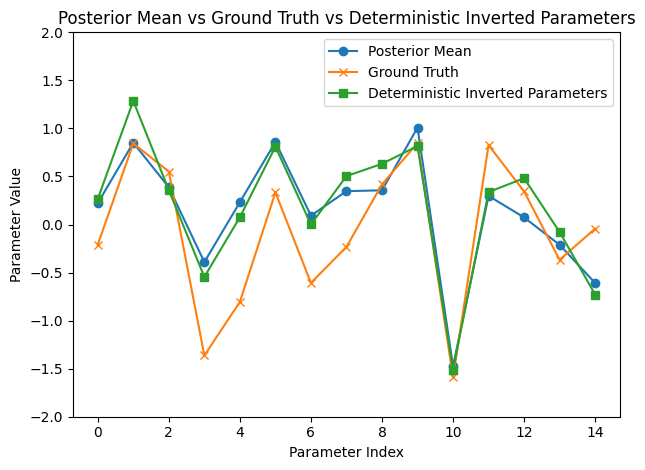

In [26]:
samples_mean = np.mean(samples, axis=0)
plt.plot(samples_mean, label='Posterior Mean', marker='o')
plt.plot(single_test_parameter, label='Ground Truth', marker='x')
plt.plot(inverted_params, label='Deterministic Inverted Parameters', marker='s')
plt.title('Posterior Mean vs Ground Truth vs Deterministic Inverted Parameters')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.legend()
plt.tight_layout()
plt.ylim(-2,2)
# plt.grid()
plt.show()

In [50]:
import pickle
import matplotlib.tri as tri

reorder_index = np.load('Heat_equation/data/reorder_vector_field.npy').astype(int)   

# Load the saved mesh data
with open('Heat_equation/data/mesh_data.pickle', 'rb') as f:
    mesh_data = pickle.load(f)

coords = mesh_data['coords']
elements = mesh_data['elements']
obs_coords = mesh_data['obs_coords']

# Create triangulation
triangulation = tri.Triangulation(coords[:, 0], coords[:, 1], elements)

def plot_domain(nodal_values, max, min, de, filename = '', save = True, cmap_plot = 'Reds', gap = 0.1, position = 'vertical', scale=1., observed_points = True):

    # Create triangulation
    triangulation = tri.Triangulation(coords[:, 0], coords[:, 1], elements)

    # Plot
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Refine the triangulation
    refiner = tri.UniformTriRefiner(triangulation)
    tri_refi, z_test_refi = refiner.refine_field(nodal_values, subdiv=3)

    # Plot contours
    levels = np.arange(min, max, de)
    cmap = plt.get_cmap(cmap_plot)
    tcf = ax.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
    cbar = plt.colorbar(tcf, shrink=scale, orientation=position, pad=0.05)
    cbar.set_ticks(np.arange(min, max, gap))

    if observed_points:
        # Plot observation points if available
        for point in obs_coords[:,0,:]:
            ax.plot(point[0], point[1], 'ks', mew=2, ms=2)


    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def from_z_to_kappa(z):
        return jnp.dot(z, jnp.transpose(jnp.dot(Eigen, Sigma)))
    

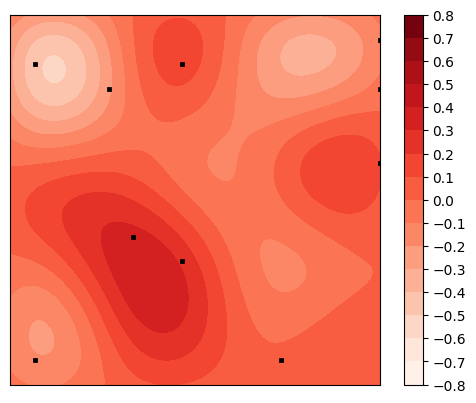

In [ ]:
nodal_values = np.asarray(from_z_to_kappa(inverted_params))
nodal_values = nodal_values[reorder_index]
max, min, de = .9, -.8, 0.1

plot_domain(nodal_values, max, min, de,save=False)

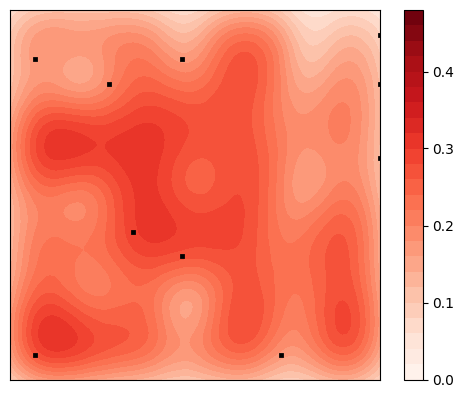

In [68]:

# standard deviation of the samples

nodal_values = np.std(np.asarray(from_z_to_kappa(samples)), axis=0)
nodal_values = nodal_values[reorder_index]
max, min, de = .5, 0, 0.02

plot_domain(nodal_values, max, min, de,save=False)